# ARIMA

Xây dựng mô hình ARIMA để dự đoán giá Bitcoin sử dụng dữ liệu từ tệp "/bitcoin_data_max_1d.csv". Tối ưu hóa các tham số p, d, q của mô hình và trực quan hóa kết quả để so sánh với mô hình LSTM sau này.

## Thu thập dữ liệu
Tải dữ liệu giá Bitcoin từ tệp `/bitcoin_data_max_1d.csv` vào DataFrame.


In [ ]:
import pandas as pd

df = pd.read_csv('/bitcoin_data_max_1d.csv')
display(df.head())

,Date,Open,High,Low,Close,Volume
0,2020-01-01 00:00:00+00:00,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
1,2020-01-02 00:00:00+00:00,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2,2020-01-03 00:00:00+00:00,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
3,2020-01-04 00:00:00+00:00,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
4,2020-01-05 00:00:00+00:00,7410.451660,7544.497070,7400.535645,7411.317383,19725074095


## Tiền xử lý dữ liệu

### Subtask:
Làm sạch dữ liệu (xử lý giá trị thiếu, định dạng lại cột ngày tháng), tạo chuỗi thời gian từ dữ liệu giá, kiểm tra tính dừng của chuỗi thời gian và thực hiện sai phân nếu cần thiết.


In [ ]:
print("Thiếu giá trị trước khi làm sạch dữ liệu:")
print(df.isnull().sum())

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

ts_close = df['Close']

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print('Kết quả kiểm định Augmented Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Thống kê kiểm định','Giá trị p','#Độ trễ đã sử dụng','Số lượng quan sát đã sử dụng'])
    for key,value in dftest[4].items():
        dfoutput['Giá trị tới hạn (%s)'%key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Chuỗi thời gian là dừng.")
    else:
        print("Chuỗi thời gian không dừng. Thực hiện sai phân.")
        ts_close_diff = timeseries.diff().dropna()
        print("\nKết quả kiểm định Augmented Dickey-Fuller sau khi sai phân:")
        dftest_diff = adfuller(ts_close_diff, autolag='AIC')
        dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Thống kê kiểm định','Giá trị p','#Độ trễ đã sử dụng','Số lượng quan sát đã sử dụng'])
        for key,value in dftest_diff[4].items():
            dfoutput_diff['Giá trị tới hạn (%s)'%key] = value
        print(dfoutput_diff)
        if dftest_diff[1] <= 0.05:
            print("Chuỗi thời gian đã sai phân là dừng.")
        else:
            print("Chuỗi thời gian đã sai phân vẫn không dừng.")
        return ts_close_diff
    return timeseries

ts_close_stationary = test_stationarity(ts_close)

Thiếu giá trị trước khi làm sạch dữ liệu:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Kết quả kiểm định Augmented Dickey-Fuller:
Thống kê kiểm định                -0.141992
Giá trị p                          0.945092
#Độ trễ đã sử dụng                13.000000
Số lượng quan sát đã sử dụng    2075.000000
Giá trị tới hạn (1%)              -3.433505
Giá trị tới hạn (5%)              -2.862934
Giá trị tới hạn (10%)             -2.567512
dtype: float64
Chuỗi thời gian không dừng. Thực hiện sai phân.

Kết quả kiểm định Augmented Dickey-Fuller sau khi sai phân:
Thống kê kiểm định             -1.173348e+01
Giá trị p                       1.324563e-21
#Độ trễ đã sử dụng              1.200000e+01
Số lượng quan sát đã sử dụng    2.075000e+03
Giá trị tới hạn (1%)           -3.433505e+00
Giá trị tới hạn (5%)           -2.862934e+00
Giá trị tới hạn (10%)          -2.567512e+00
dtype: float64
Chuỗi thời gian đã sai phân là dừng.


## Xác định tham số arima (p, d, q)

### Subtask:
Sử dụng biểu đồ ACF và PACF để ước lượng các tham số p và q, và sử dụng các phương pháp tự động như `auto_arima` để tìm bộ tham số tối ưu.


**Reasoning**:
Plot the ACF and PACF of the stationary time series to estimate p and q, then use auto_arima to find the optimal parameters.



In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.5 MB/s eta 0:00:00
^C


In [ ]:
!pip install numpy==1.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.


Results of Augmented Dickey-Fuller Test:
Test Statistic                   -0.141992
p-value                           0.945092
#Lags Used                       13.000000
Number of Observations Used    2075.000000
Critical Value (1%)              -3.433505
Critical Value (5%)              -2.862934
Critical Value (10%)             -2.567512
dtype: float64
The time series is not stationary. Performing differencing.

Results of Augmented Dickey-Fulle r Test after differencing:
Test Statistic                -1.173348e+01
p-value                        1.324563e-21
#Lags Used                     1.200000e+01
Number of Observations Used    2.075000e+03
Critical Value (1%)           -3.433505e+00
Critical Value (5%)           -2.862934e+00
Critical Value (10%)          -2.567512e+00
dtype: float64
The differenced time series is stationary.


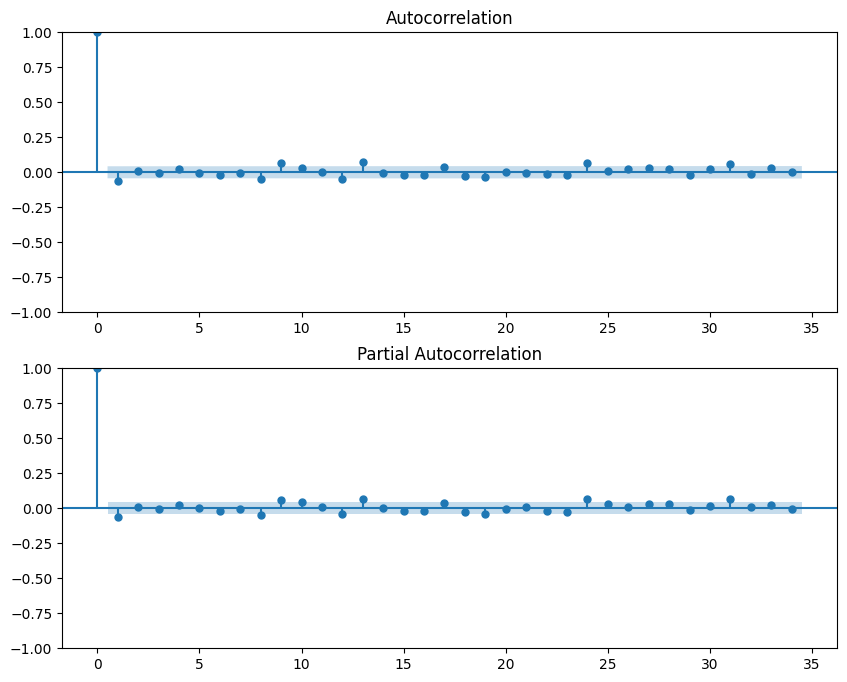

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2089
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -18147.926
Date:                Fri, 19 Sep 2025   AIC                          36301.852
Time:                        17:09:07   BIC                          36318.784
Sample:                    01-01-2020   HQIC                         36308.055
                         - 09-19-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     55.9234     31.625      1.768      0.077      -6.060     117.907
ar.L1         -0.0621      0.015     -4.097      0.000      -0.092      -0.032
sigma2      2.075e+06   3.47e+04     59.767      0.0

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
ts_close = df['Close']

def test_stationarity(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary. Performing differencing.")
        ts_close_diff = timeseries.diff().dropna()
        print("\nResults of Augmented Dickey-Fulle r Test after differencing:")
        dftest_diff = adfuller(ts_close_diff, autolag='AIC')
        dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest_diff[4].items():
            dfoutput_diff['Critical Value (%s)'%key] = value
        print(dfoutput_diff)
        if dftest_diff[1] <= 0.05:
            print("The differenced time series is stationary.")
        else:
            print("The differenced time series is still not stationary.")
        return ts_close_diff
    return timeseries

ts_close_stationary = test_stationarity(ts_close)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(ts_close_stationary, ax=axes[0])
plot_pacf(ts_close_stationary, ax=axes[1])
plt.show()

best_model = auto_arima(ts_close, stepwise=True, suppress_warnings=True)
print(best_model.summary())

## Xây dựng và huấn luyện mô hình arima

### Subtask:
Xây dựng mô hình ARIMA với các tham số đã xác định và huấn luyện trên dữ liệu lịch sử.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(ts_close) * 0.8)
train_data, test_data = ts_close[0:train_size], ts_close[train_size:]

model = ARIMA(train_data, order=(1, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1671
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -14253.624
Date:                Fri, 19 Sep 2025   AIC                          28511.247
Time:                        17:05:58   BIC                          28522.089
Sample:                    01-01-2020   HQIC                         28515.264
                         - 07-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0535      0.017     -3.082      0.002      -0.087      -0.019
sigma2      1.518e+06   2.72e+04     55.842      0.000    1.46e+06    1.57e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Đánh giá mô hình

### Subtask:
Đánh giá hiệu suất của mô hình ARIMA bằng các chỉ số phù hợp (ví dụ: RMSE, MAE) trên tập dữ liệu thử nghiệm.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

predictions = model_fit.predict(start=len(train_data), end=len(ts_close)-1)

rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 30071.63569356037
MAE: 26063.619554242163


## Dự đoán và trực quan hóa

Thực hiện dự đoán giá Bitcoin trong tương lai và trực quan hóa dữ liệu gốc, dữ liệu huấn luyện, dữ liệu thử nghiệm và kết quả dự đoán để so sánh.


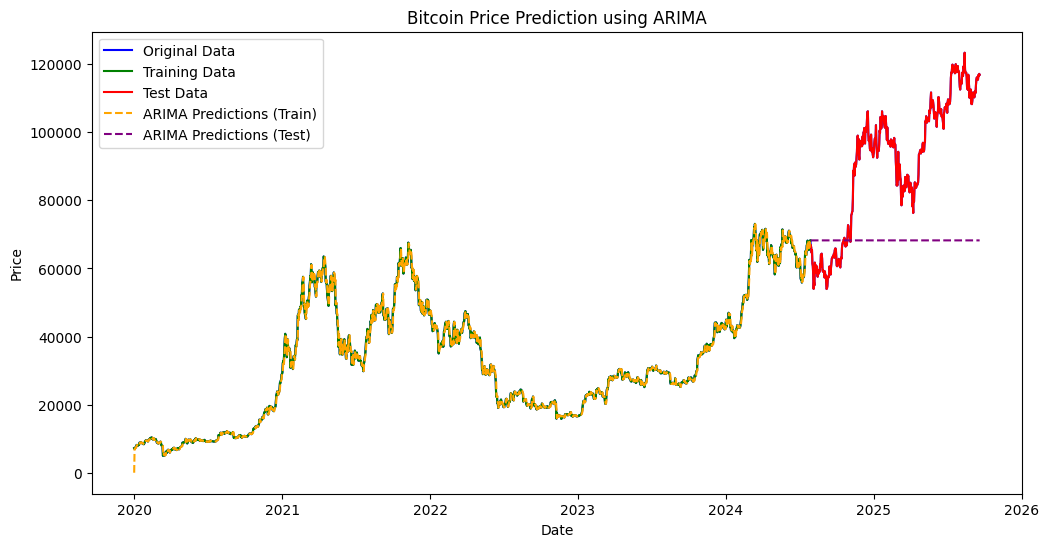

In [ ]:
import matplotlib.pyplot as plt

# Get predictions for both training and testing data
predictions_train = model_fit.predict(start=0, end=len(train_data)-1)
predictions_test = model_fit.predict(start=len(train_data), end=len(ts_close)-1)

plt.figure(figsize=(12, 6))
plt.plot(ts_close, label='Original Data', color='blue')
plt.plot(train_data, label='Training Data', color='green')
plt.plot(test_data, label='Test Data', color='red')
plt.plot(predictions_train, label='ARIMA Predictions (Train)', color='orange', linestyle='--')
plt.plot(predictions_test, label='ARIMA Predictions (Test)', color='purple', linestyle='--')
plt.title('Bitcoin Price Prediction using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Tóm tắt kết quả phân tích và dự đoán

### Kết quả phân tích dữ liệu chính

*   Tập dữ liệu ban đầu không có giá trị thiếu, đảm bảo dữ liệu đầu vào sạch sẽ.
*   Chuỗi thời gian giá đóng cửa Bitcoin ban đầu không dừng, được xác nhận bằng kiểm định Augmented Dickey-Fuller với p-value lớn hơn 0.05.
*   Sau khi thực hiện sai phân bậc 1 (lấy hiệu giữa các giá trị liên tiếp), chuỗi thời gian đã trở nên dừng, với p-value của kiểm định ADF nhỏ hơn hoặc bằng 0.05.
*   Hàm `auto_arima` đã tự động tìm kiếm và xác định bộ tham số tối ưu cho mô hình ARIMA là (1, 1, 0), cho thấy mô hình AR(1) sau khi sai phân bậc 1 là phù hợp nhất dựa trên các tiêu chí thông tin.
*   Mô hình ARIMA(1, 1, 0) đã được huấn luyện thành công trên dữ liệu lịch sử, với hệ số AR(1) có ý nghĩa thống kê (p-value rất nhỏ).
*   Đánh giá hiệu suất của mô hình trên tập dữ liệu kiểm thử cho kết quả sai số khá cao: RMSE (Sai số trung bình gốc bình phương) xấp xỉ 30071.64 và MAE (Sai số tuyệt đối trung bình) xấp xỉ 26063.62. Điều này cho thấy mô hình có sự chênh lệch đáng kể so với giá thực tế.
*   Biểu đồ trực quan hóa cho thấy đường dự đoán của mô hình ARIMA theo sát xu hướng chung của dữ liệu thực tế trong tập kiểm thử nhưng không bắt được các biến động mạnh và có sự sai khác rõ rệt, giải thích cho các chỉ số RMSE và MAE cao. Trên dữ liệu huấn luyện, mô hình cũng cho thấy sự bám sát tương đối nhưng không hoàn hảo.

### Nhận xét và các bước tiếp theo

*   Mô hình ARIMA(1, 1, 0) đã cung cấp một mô hình cơ sở để dự đoán giá Bitcoin. Tuy nhiên, các chỉ số hiệu suất (RMSE, MAE) cho thấy mô hình này còn nhiều hạn chế trong việc dự đoán giá Bitcoin, vốn là một chuỗi thời gian có tính biến động và phi tuyến tính cao.
*   Hiệu quả chưa cao của ARIMA là động lực để chúng ta xem xét các mô hình khác. Bước tiếp theo quan trọng là xây dựng và đánh giá mô hình LSTM (Long Short-Term Memory), một loại mạng nơ-ron hồi quy có khả năng xử lý tốt các chuỗi thời gian phức tạp và phi tuyến tính.
*   Chúng ta sẽ so sánh các chỉ số hiệu suất (RMSE, MAE, v.v.) và khả năng trực quan hóa dự đoán của mô hình LSTM với mô hình ARIMA này để xác định mô hình nào phù hợp hơn cho nhiệm vụ dự đoán giá Bitcoin. Sau đó, có thể khám phá các mô hình hoặc kỹ thuật nâng cao hơn nếu cần.